In [1]:
import json
import os
import pandas as pd
import isodate
import requests
import numpy as np
import cv2
from collections import Counter
from sklearn.cluster import KMeans
import time
from tqdm import tqdm
import random
from collections import Counter, defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import ast
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
import matplotlib.pyplot as plt
import seaborn as sns

In [31]:
df=pd.read_csv("model_datas.csv", encoding="utf-8-sig")
df

,Unnamed: 0,view_count,duration,subscriber_count,brightness,contrast,title_length,word_count,emoji_count,special_char_count,...,person_small,person_medium,person_large,text_left,text_middle,text_right,text_small,text_medium,text_large,cluster
0,0,244420.0,459.0,412000.0,109.295617,50.267187,17,9,0,0,...,0,1,1,0,0,0,0,0,0,7
1,1,11267.0,1117.0,46500.0,109.632415,78.918197,98,37,3,9,...,0,1,1,0,1,1,0,2,1,7
2,2,12158.0,1306.0,15700.0,93.686517,89.278624,22,12,0,1,...,3,5,5,0,0,0,0,0,0,3
3,3,14333.0,1772.0,71700.0,139.081451,66.674994,99,50,1,4,...,0,1,1,0,3,1,2,3,3,0
4,4,58409.0,1097.0,296000.0,137.706521,74.693199,55,32,3,5,...,0,1,1,3,3,2,0,5,4,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7303,7303,59924.0,890.0,45200.0,169.503289,74.661909,56,21,4,5,...,0,1,1,1,3,0,1,3,3,3
7304,7304,348120.0,2072.0,682000.0,104.467790,70.103093,47,20,0,5,...,0,2,2,0,0,0,0,0,0,3
7305,7305,857932.0,584.0,552000.0,106.026044,67.129156,43,9,0,2,...,0,1,1,0,0,0,0,0,0,3
7306,7306,2799502.0,1351.0,552000.0,127.653263,62.304253,23,9,0,0,...,0,1,1,0,1,0,0,1,1,3


In [25]:
df_cluster=pd.read_csv("updated_cluster.csv", encoding="utf-8-sig")
df_cluster=df_cluster.iloc[:,-1]
df['cluster']=df_cluster

In [9]:
df['log_view_count'] = np.log1p(df['view_count'])

In [11]:
from sklearn.preprocessing import StandardScaler
numeric_cols = ['duration', 'subscriber_count', 'brightness', 'contrast']
scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [13]:
df['has_question_mark'] = df['has_question_mark'].astype(int)
df['has_exclamation'] = df['has_exclamation'].astype(int)

In [15]:
X = df.drop(columns=['view_count', 'log_view_count'])
y = df['log_view_count']

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [34]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R-squared: {r2:.4f}")

RMSE: 1.55
R-squared: 0.4226


## 클러스터링

In [11]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sentence_transformers import SentenceTransformer
from tqdm import tqdm
import numpy as np

# 데이터 로드
title_df = pd.read_csv("final_video_data.csv", encoding="utf-8-sig")
title_df

C:\Users\duwjd\anaconda3\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


,Unnamed: 0,title_x,video_id,published_date,thumbnail_url,view_count,like_count,comment_count,duration,channel_id,...,emoji_count,has_emoji,special_char_count,is_clickbait,has_question_mark,has_exclamation,top_noun_1,top_noun_2,top_noun_3,cluster
0,0,결국 긴팔문신 제거 하는 조두팔,t-zwVkTOZA8,2025-03-28,https://i.ytimg.com/vi/t-zwVkTOZA8/maxresdefau...,244420.0,NaN,221.0,459.0,"('조두팔', '@조두팔이라고')",...,0,0,0,0,False,False,문신,제거,NaN,100
1,1,[vlog] 고등학교 교사 직장인 브이로그 | 학부모 총회 그리고 상담 가득한 한 ...,AMwSEsFVRGg,2025-03-28,https://i.ytimg.com/vi/AMwSEsFVRGg/maxresdefau...,11267.0,265.0,54.0,1117.0,"('HappyHojin', '@Happppyhojin')",...,3,1,9,0,False,False,고등학교,교사,직장인,101
2,2,오사카&교토 브이로그 • 쇼핑에미띤여자들,PocqBywf0FU,2025-02-24,https://i.ytimg.com/vi/PocqBywf0FU/maxresdefau...,12158.0,315.0,110.0,1306.0,"('권예왕왕', '@ye_one_e')",...,0,0,1,0,False,False,오사카,교토,쇼핑,102
3,3,마라로제엽떡+닭꼬치 꿀조합•노티드 딸기전메뉴🍓먹고 결국 컵라면2개로 마무리•옛날통닭...,6eNhJ4LYr1k,2025-03-29,https://i.ytimg.com/vi/6eNhJ4LYr1k/maxresdefau...,14333.0,441.0,71.0,1772.0,"('째링', '@buttermellowday')",...,1,1,4,0,False,False,엽떡,닭꼬치,조합,101
4,4,[썰레디윗미] 이젠 말할 수 있다🙄 역대급 똥차 썰 낋여오니라.ㅣ이게 실화라고? 구...,G9tXGudpOCo,2025-03-28,https://i.ytimg.com/vi/G9tXGudpOCo/maxresdefau...,58409.0,NaN,118.0,1097.0,"('냔지 nyanji', '@quya_a')",...,3,1,5,1,True,False,레디,역대,똥차,101
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7303,7303,(광고❌) 지금 바로 적용되는 저렴한 호텔 예약 꿀팁 🧑🏻‍💻 이건 몰랐을걸..절대...,GPWGgXXT1Aw,2025-01-31,https://i.ytimg.com/vi/GPWGgXXT1Aw/maxresdefau...,59924.0,1928.0,64.0,890.0,"('시월필름 October-film', '@시월필름')",...,4,1,5,0,False,True,광고,지금,바로,3
7304,7304,"12월에 또 갈 결심(온천호텔, 탄금호 캠핑장, 커피 주는 박물관, 한복 셀프사진관)",Q5uzsA3_oTE,2024-11-29,https://i.ytimg.com/vi/Q5uzsA3_oTE/maxresdefau...,348120.0,11536.0,1000.0,2072.0,"('[하말넘많] heavytalker', '@heavytalker')",...,0,0,5,0,False,False,결심,온천,호텔,3
7305,7305,일본 캡슐호텔에서 50시간 살아보기 | 일본#2,ZDUE_TI-od8,2024-07-01,https://i.ytimg.com/vi/ZDUE_TI-od8/maxresdefau...,857932.0,8408.0,676.0,584.0,"('서재로36', '@서재로36')",...,0,0,2,0,False,False,일본,NaN,NaN,3
7306,7306,세계에서 가장 작은 나라의 가장 작은 호텔,ubnBh-HRcrc,2023-12-25,https://i.ytimg.com/vi/ubnBh-HRcrc/maxresdefau...,2799502.0,25017.0,1200.0,1351.0,"('서재로36', '@서재로36')",...,0,0,0,0,False,False,가장,세계,나라,3


In [81]:
model = SentenceTransformer("jhgan/ko-sbert-sts")  # HuggingFace 모델
title_embeddings = model.encode(title_df['title_x'].tolist(), show_progress_bar=True)

# 메타데이터 선택 및 정규화
meta_features = ['duration','title_length', 'word_count']
X_meta = title_df[meta_features].fillna(0)
X_meta_scaled = StandardScaler().fit_transform(X_meta)

X_combined = np.hstack([X_meta_scaled, title_embeddings])

Batches:   0%|          | 0/229 [00:00<?, ?it/s]

In [12]:
embedding_df = pd.DataFrame({
    'video_id': title_df['video_id'],
    'title': title_df['title_x'],
    'embedding': list(title_embeddings)
})

embedding_df.to_csv("title_embeddings.csv", index=False)

In [64]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
import numpy as np

def find_optimal_k(feature_matrix, k_range=range(2, 11), random_state=42):
    wcss = []
    silhouette_scores = []
    db_scores = []

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=random_state)
        labels = kmeans.fit_predict(feature_matrix)

        wcss.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(feature_matrix, labels))
        db_scores.append(davies_bouldin_score(feature_matrix, labels))

    # 📊 시각화
    fig, ax = plt.subplots(1, 3, figsize=(18, 5))

    ax[0].plot(k_range, wcss, marker='o')
    ax[0].set_title('Elbow Method (WCSS)')
    ax[0].set_xlabel('Number of Clusters (k)')
    ax[0].set_ylabel('WCSS')

    ax[1].plot(k_range, silhouette_scores, marker='o', color='green')
    ax[1].set_title('Silhouette Score')
    ax[1].set_xlabel('Number of Clusters (k)')
    ax[1].set_ylabel('Score')

    ax[2].plot(k_range, db_scores, marker='o', color='red')
    ax[2].set_title('Davies-Bouldin Index')
    ax[2].set_xlabel('Number of Clusters (k)')
    ax[2].set_ylabel('Index (Lower is better)')

    plt.tight_layout()
    plt.show()

    best_silhouette_k = k_range[np.argmax(silhouette_scores)]
    best_db_k = k_range[np.argmin(db_scores)]

    print(f"\n Silhouette Score 기준 최적 k: {best_silhouette_k}")
    print(f" Davies-Bouldin Index 기준 최적 k: {best_db_k}")

    return {
        "silhouette_best_k": best_silhouette_k,
        "dbi_best_k": best_db_k,
        "wcss": wcss,
        "silhouette_scores": silhouette_scores,
        "db_scores": db_scores
    }


C:\Users\duwjd\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\duwjd\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\duwjd\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\duwjd\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

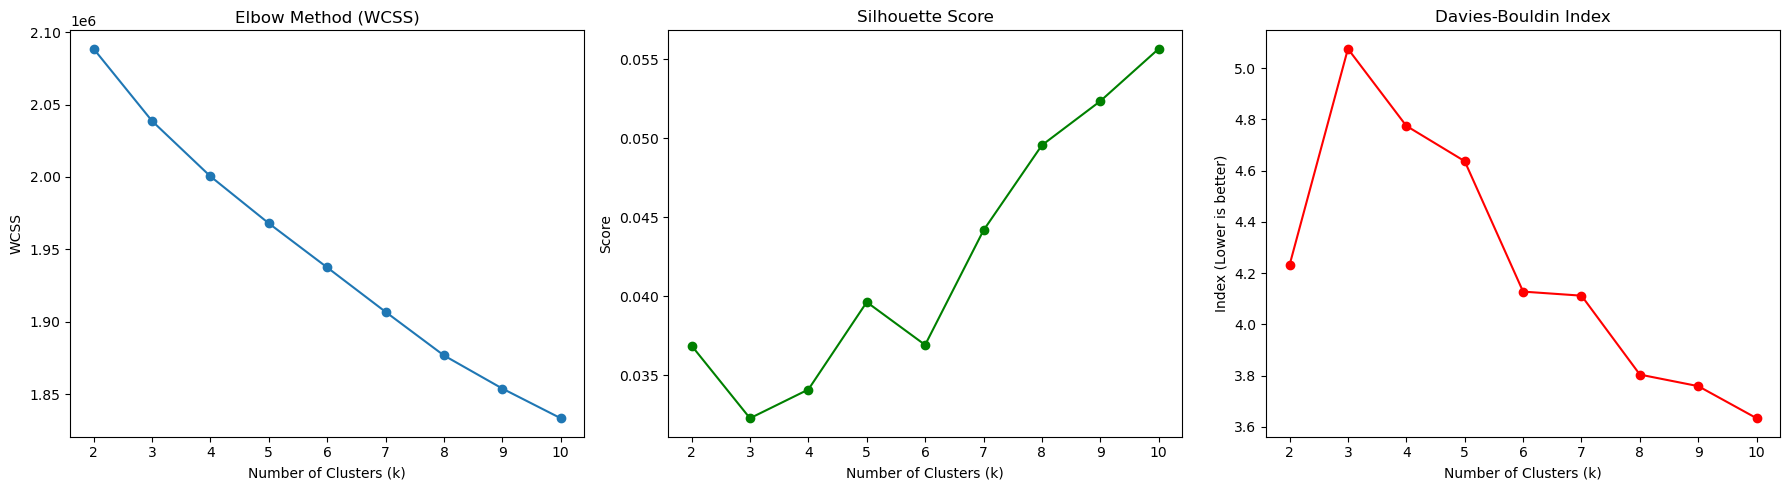


✅ Silhouette Score 기준 최적 k: 10
✅ Davies-Bouldin Index 기준 최적 k: 10


In [66]:
# title_embeddings + duration, title_length, word_count 포함된 통합 피처
result = find_optimal_k(X_combined, k_range=range(2, 11))

In [82]:
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
title_df['cluster'] = kmeans.fit_predict(X_combined)

for i in range(n_clusters):
    print(f"\n🔹 클러스터 {i} 예시 제목:")
    print(title_df[title_df['cluster'] == i]['title_x'].head(3).to_string(index=False))

print(title_df['cluster'].value_counts().sort_index())

C:\Users\duwjd\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



🔹 클러스터 0 예시 제목:
마라로제엽떡+닭꼬치 꿀조합•노티드 딸기전메뉴🍓먹고 결국 컵라면2개로 마무리•옛날통닭 ...
vlog | 집순이의 주말 삼시세끼 집밥 🛋️ 💭  두툼한 함박스테이크가 올라간 투움...
                                 한국 와서 오지게 먹는 브이로그

🔹 클러스터 1 예시 제목:
          아오니의 혼자 새 닌텐도 사러가는 브이로그★ (feat.세번째섬)
오징어게임2 3분 요약 [Squid Game II 3 Minutes Summary]
               왜 아이폰에서 제일 재밌는 게임이 닌텐도가 되어버렸을까?

🔹 클러스터 2 예시 제목:
       광기 다이어터의 72시간 밀착 브이로그 | 정신 차리고 다이어트 시작🏃‍♀️🚨
        [다이어트브이로그#2] 3일동안 계란이랑 단백질바만 먹으면 얼마나 빠질까?🥚
출산특집#6 먹어야 회복하지!! 자연분만 산모 회복 브이로그, 출산 직후 뭘 먹나? ...

🔹 클러스터 3 예시 제목:
                            오사카&교토 브이로그 • 쇼핑에미띤여자들
[VLOG] 일상 브이로그 | 3월 나의 생일을 맞이하며..🌷 | 이재모피자 제주점 ...
                           둘째 임신했습니다!!!🎉 (연년생 확정😭)

🔹 클러스터 4 예시 제목:
저 드디어 강남에 샵 오픈했어요😭취향 가득 담은 제 샵을 소개합니다🤍 | 인테리어 브...
                                  나 말고 송혜교 브이로그...
 vlog 딸빼고 엄마아빠 데이트👩‍❤‍👨리빙페어, 하이디라오 첫도전, 커트러리&잠옷 쇼핑

🔹 클러스터 5 예시 제목:
                  집도 없고 차도 없는 서민의 인생 첫 명품하울 브이로그
페라리의 나라에서 온 이탈리아 장인어른이 제네시스G90을 보고 두눈을 의심한 이유 ㅎㅎ
                               천만원짜리 카니발 풀옵션 만들

In [87]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 결과 저장용 리스트
cluster_results = []

# 타겟 변수 (로그 변환한 조회수)
df['target'] = np.log1p(df['view_count'])  # views 컬럼명에 따라 조정

# 사용할 feature 컬럼 지정 (title_length, duration, 색상, 객체 등 자유롭게)
feature_cols = [
    'duration', 'subscriber_count', 'brightness', 'contrast',
       'title_length', 'word_count', 'emoji_count',
       'special_char_count', 'is_clickbait', 'has_question_mark',
       'has_exclamation', 'pub_year', 'pub_month', 'pub_weekday', 'color_red',
       'color_blue', 'color_green', 'color_yellow', 'color_purple',
       'color_brown', 'color_grey', 'color_white', 'color_pink',
       'person_count', 'object_count', 'has_text', 'person_left',
       'person_middle', 'person_right', 'person_small', 'person_medium',
       'person_large', 'text_left', 'text_middle', 'text_right', 'text_small',
       'text_medium', 'text_large'
]

# 군집별로 반복
for cluster_id in sorted(df['cluster'].unique()):
    cluster_df = df[df['cluster'] == cluster_id]
    
    if len(cluster_df) < 20:
        print(f"클러스터 {cluster_id} 데이터 수가 적어 스킵됨: {len(cluster_df)}개")
        continue

    X = cluster_df[feature_cols]
    y = cluster_df['target']

    # 훈련/테스트 분리
    from sklearn.model_selection import train_test_split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # 모델 학습
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)

    # 예측
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # 결과 저장
    cluster_results.append({
        'cluster': cluster_id,
        'rmse': rmse,
        'r2': r2,
        'sample_size': len(cluster_df)
    })

    print(f"클러스터 {cluster_id}: RMSE = {rmse:.4f}, R² = {r2:.4f}")


클러스터 0: RMSE = 1.1829, R² = 0.6026
클러스터 1: RMSE = 1.0515, R² = 0.5166
클러스터 2: RMSE = 1.1980, R² = 0.6830
클러스터 3: RMSE = 1.6990, R² = 0.3217
클러스터 4: RMSE = 1.0337, R² = 0.5816
클러스터 5: RMSE = 1.1968, R² = 0.3005
클러스터 6: RMSE = 1.7755, R² = 0.2649
클러스터 7: RMSE = 1.6063, R² = 0.4719
클러스터 8: RMSE = 1.1273, R² = 0.5080
클러스터 9: RMSE = 1.9965, R² = 0.0978


In [155]:
### 클러스터 quantile 나눠서 다시 해보기
cluster_9_df = df[df['cluster'] == 9]
q98 = cluster_9_df['view_count'].quantile(0.98)
trimmed_df = cluster_9_df[cluster_9_df['view_count'] <= q98].copy()

# 타깃: 로그 변환된 조회수
trimmed_df['target'] = np.log1p(trimmed_df['view_count'])

X = trimmed_df[feature_cols]
y = trimmed_df['target']

# 학습/테스트 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 모델 학습
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# 예측 및 성능 평가
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}, R²: {r2:.4f}")

RMSE: 1.8615, R²: 0.2066


### 재클러스터링 (R스퀘어값 낮은 5,6,9만)

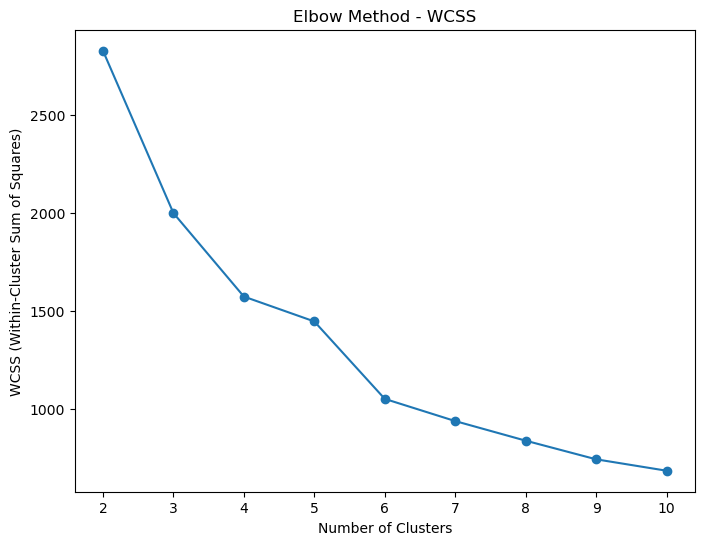

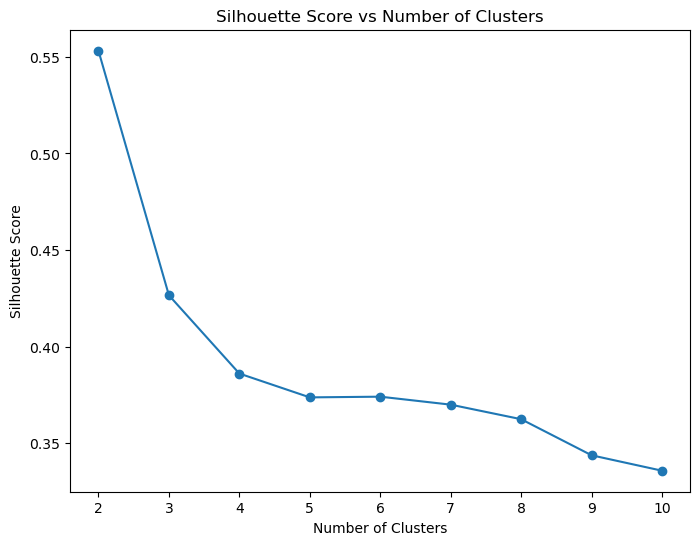

Optimal number of clusters (based on silhouette score): 2


In [137]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
from sklearn.preprocessing import StandardScaler

# 1. 파일 로드
df = title_df
embeddings_df = pd.read_csv("title_embeddings.csv")  # title_embeddings 저장된 csv

# 2. 필요한 컬럼 확인
meta_features = ['duration', 'title_length', 'word_count']
assert all(col in df.columns for col in meta_features + ['cluster'])

# 3. 타겟 클러스터만 선택
target_clusters = [8,9,10]
sub_df = df[df['cluster'].isin(target_clusters)].copy()

# 4. 임베딩 연결 (video_id 등으로 merge)
sub_df = sub_df.merge(embeddings_df, on='video_id', how='left')

# 5. 임베딩 컬럼 리스트로 변환
embedding_cols = [col for col in embeddings_df.columns if col.startswith('embed_')]
embedding_matrix = sub_df[embedding_cols].values

# 6. 메타 정규화
from sklearn.preprocessing import StandardScaler
meta_scaled = StandardScaler().fit_transform(sub_df[meta_features].fillna(0))

# 7. 벡터 결합
X_combined = np.hstack([meta_scaled, embedding_matrix])

# 8. 최적 클러스터 수 찾기 (Elbow Method와 Silhouette Score 사용)

# Elbow Method (WCSS)
wcss = []
silhouette_scores = []
max_clusters = 10  # 최대로 시도할 클러스터 수

for n_clusters in range(2, max_clusters + 1):  # 2부터 max_clusters까지 클러스터 수 변화
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init="auto")
    kmeans.fit(X_combined)
    
    # WCSS 계산 (Elbow Method용)
    wcss.append(kmeans.inertia_)
    
    # Silhouette Score 계산
    score = silhouette_score(X_combined, kmeans.labels_)
    silhouette_scores.append(score)

# Elbow Method 그래프
plt.figure(figsize=(8, 6))
plt.plot(range(2, max_clusters + 1), wcss, marker='o')
plt.title('Elbow Method - WCSS')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.show()

# Silhouette Score 그래프
plt.figure(figsize=(8, 6))
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.title('Silhouette Score vs Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()

# 최적 클러스터 수 선택 (Silhouette Score 기준)
optimal_clusters = silhouette_scores.index(max(silhouette_scores)) + 2  # 최대값에 해당하는 클러스터 수
print(f"Optimal number of clusters (based on silhouette score): {optimal_clusters}")

# 9. KMeans 클러스터링 (최적 클러스터 수 사용)
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init="auto")
sub_df['recluster'] = kmeans.fit_predict(X_combined)

DBSCAN Silhouette Score: 0.33377634570469844


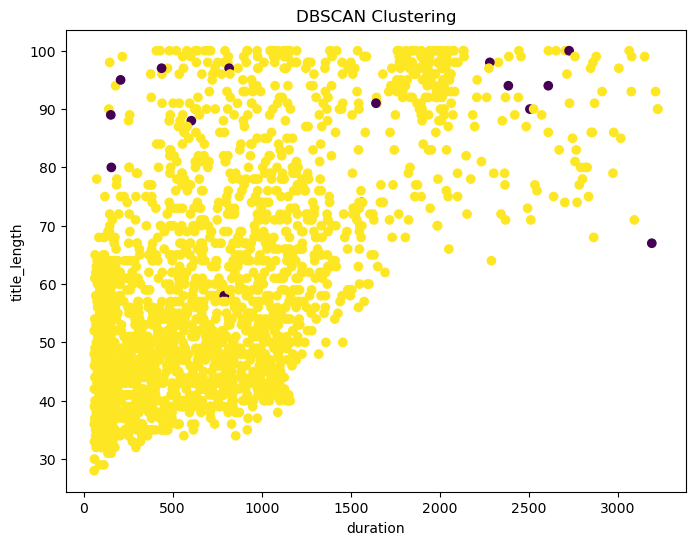

Agglomerative Clustering Silhouette Score: 0.36705815259975544


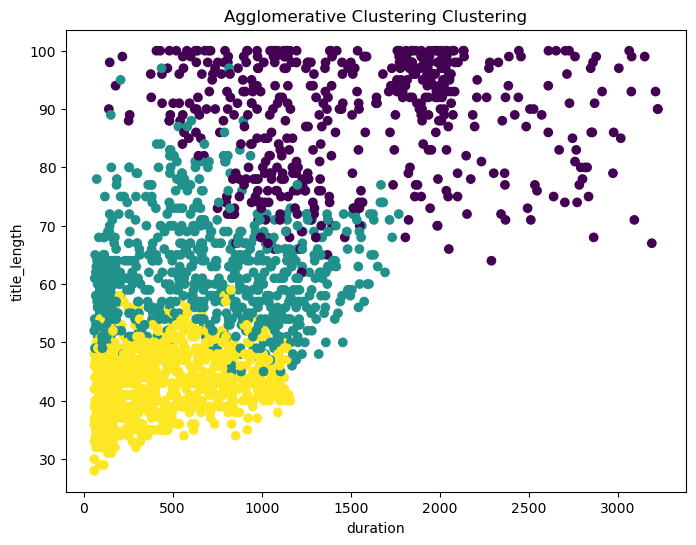

Gaussian Mixture Model Silhouette Score: 0.22667807669581833


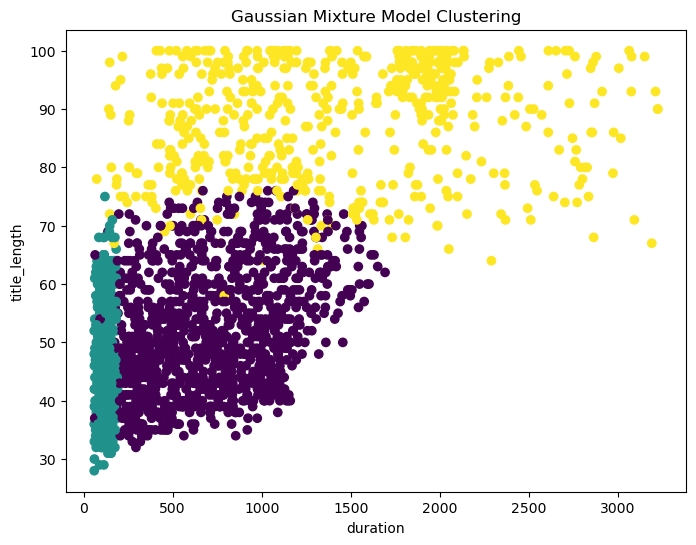

      video_id  recluster
0  DePBBfhQfGE          0
1  vtQ0KhiEP9U          2
2  4p497_IPaSU          0
3  kuFVtsAkgzI          2
4  SuWGN3kvVfo          2


In [115]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

# 1. 파일 로드
df = title_df
embeddings_df = pd.read_csv("title_embeddings.csv")  # title_embeddings 저장된 csv

# 2. 필요한 컬럼 확인
meta_features = ['duration', 'title_length', 'word_count']
assert all(col in df.columns for col in meta_features + ['cluster'])

# 3. 타겟 클러스터만 선택
target_clusters = [8,9]
sub_df = df[df['cluster'].isin(target_clusters)].copy()

# 4. 임베딩 연결 (video_id 등으로 merge)
sub_df = sub_df.merge(embeddings_df, on='video_id', how='left')

# 5. 임베딩 컬럼 리스트로 변환
embedding_cols = [col for col in embeddings_df.columns if col.startswith('embed_')]
embedding_matrix = sub_df[embedding_cols].values

# 6. 메타 정규화
meta_scaled = StandardScaler().fit_transform(sub_df[meta_features].fillna(0))

# 7. 벡터 결합
X_combined = np.hstack([meta_scaled, embedding_matrix])

# 클러스터링 알고리즘 리스트
clustering_algorithms = {
    'DBSCAN': DBSCAN(eps=0.5, min_samples=5),
    'Agglomerative Clustering': AgglomerativeClustering(n_clusters=3),
    'Gaussian Mixture Model': GaussianMixture(n_components=3, random_state=42)
}

# 8. 클러스터링 알고리즘 수행 및 성능 평가
for name, algorithm in clustering_algorithms.items():
    sub_df['recluster'] = algorithm.fit_predict(X_combined)
    
    # Silhouette Score 계산
    if len(set(sub_df['recluster'])) > 1:  # 군집이 1개일 경우는 Silhouette Score 계산 안함
        score = silhouette_score(X_combined, sub_df['recluster'])
        print(f"{name} Silhouette Score: {score}")
    else:
        print(f"{name} - No valid clusters formed.")
    
    # 결과 시각화
    plt.figure(figsize=(8, 6))
    plt.scatter(sub_df[meta_features[0]], sub_df[meta_features[1]], c=sub_df['recluster'], cmap='viridis')
    plt.title(f'{name} Clustering')
    plt.xlabel(meta_features[0])
    plt.ylabel(meta_features[1])
    plt.show()

# 결과 확인
print(sub_df[['video_id', 'recluster']].head())

In [139]:
print(sub_df['recluster'].value_counts().sort_index())

0     691
1    1727
Name: recluster, dtype: int64


In [141]:
# 9. 기존 df에 반영
for i in range(len(sub_df)):
    df.iloc[sub_df.iloc[i,0], 30] = sub_df.iloc[i,34] + 100  # 예: 새 cluster 100~102로 할당
print(df['cluster'].value_counts().sort_index())

0       697
1       225
2       264
3       452
4      1678
5       219
6       766
7       589
100     691
101    1727
Name: cluster, dtype: int64


In [143]:
cluster_mapping = {
    0: 0,
    1: 1,
    2: 2,
    3: 3,
    4: 4,
    5: 5,
    6: 6,
    7: 7,
    100: 8,
    101: 9
}

# 'cluster' 칼럼에서 기존 값을 새로운 값으로 변환
df['cluster'] = df['cluster'].replace(cluster_mapping)

In [145]:
df_1=pd.read_csv("model_datas.csv", encoding="utf-8-sig")
df_1['cluster']=df['cluster']
df=df_1
df

,Unnamed: 0,view_count,duration,subscriber_count,brightness,contrast,title_length,word_count,emoji_count,special_char_count,...,person_small,person_medium,person_large,text_left,text_middle,text_right,text_small,text_medium,text_large,cluster
0,0,244420.0,459.0,412000.0,109.295617,50.267187,17,9,0,0,...,0,1,1,0,0,0,0,0,0,4
1,1,11267.0,1117.0,46500.0,109.632415,78.918197,98,37,3,9,...,0,1,1,0,1,1,0,2,1,4
2,2,12158.0,1306.0,15700.0,93.686517,89.278624,22,12,0,1,...,3,5,5,0,0,0,0,0,0,6
3,3,14333.0,1772.0,71700.0,139.081451,66.674994,99,50,1,4,...,0,1,1,0,3,1,2,3,3,0
4,4,58409.0,1097.0,296000.0,137.706521,74.693199,55,32,3,5,...,0,1,1,3,3,2,0,5,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7303,7303,59924.0,890.0,45200.0,169.503289,74.661909,56,21,4,5,...,0,1,1,1,3,0,1,3,3,9
7304,7304,348120.0,2072.0,682000.0,104.467790,70.103093,47,20,0,5,...,0,2,2,0,0,0,0,0,0,7
7305,7305,857932.0,584.0,552000.0,106.026044,67.129156,43,9,0,2,...,0,1,1,0,0,0,0,0,0,6
7306,7306,2799502.0,1351.0,552000.0,127.653263,62.304253,23,9,0,0,...,0,1,1,0,1,0,0,1,1,6


In [148]:
df.to_csv('model_datas.csv', encoding='utf-8-sig')

In [147]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Ridge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from tqdm import tqdm

# 로그 변환된 타겟 생성
df['target'] = np.log1p(df['view_count'])

# 사용할 회귀 모델들 정의
model_list = {
    "RandomForest": RandomForestRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42),
    "LightGBM": LGBMRegressor(random_state=42,
    min_data_in_leaf=5,         
    min_gain_to_split=0.0,       
    n_estimators=100,
    learning_rate=0.05),
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "GradientBoosting": GradientBoostingRegressor(random_state=42)
}

# 결과 저장용 리스트
cluster_model_results = []

# 군집별 반복
for cluster_id in sorted(df['cluster'].unique()):
    cluster_df = df[df['cluster'] == cluster_id].copy()

    if len(cluster_df) < 20:
        print(f"클러스터 {cluster_id}은 샘플 부족 → 스킵됨 ({len(cluster_df)}개)")
        continue

    X = cluster_df[feature_cols]
    y = cluster_df['target']

    # 훈련/테스트 분리
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    best_model_name = None
    best_model_score = -np.inf
    best_rmse = None

    for name, model in model_list.items():
        try:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            r2 = r2_score(y_test, y_pred)

            if r2 > best_model_score:
                best_model_name = name
                best_model_score = r2
                best_rmse = rmse

        except Exception as e:
            print(f"[{name}] 모델 오류 in 클러스터 {cluster_id}: {e}")
            continue

    cluster_model_results.append({
        "cluster": cluster_id,
        "best_model": best_model_name,
        "rmse": round(best_rmse, 4),
        "r2": round(best_model_score, 4),
        "sample_size": len(cluster_df)
    })

results_df = pd.DataFrame(cluster_model_results).sort_values(by="r2", ascending=False)
print(results_df)

[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1050
[LightGBM] [Info] Number of data points in the train set: 557, number of used features: 38
[LightGBM] [Info] Start training from score 12.431337
[LightGBM] [Warning] min_data_in_leaf is set=5, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=5
[LightGBM] [Warning] min_gain_to_split is set=0.0, 

## 모델학습

In [ ]:
import optuna
from tqdm import tqdm
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 각 클러스터에 대해 최적 모델 지정
cluster_best_models = {
    0: "LightGBM",
    1: "GradientBoosting",
    2: "RandomForest",
    3: "LightGBM",
    4: "LightGBM",
    5: "RandomForest",
    6: "RandomForest",
    7: "XGBoost",
    8: "LightGBM",
    9: "RandomForest"
}

# 모델 저장용 딕셔너리
trained_models = []
optuna_results = []

# 피처 컬럼
feature_cols = [
    'duration', 'subscriber_count', 'brightness', 'contrast',
    'title_length', 'word_count', 'emoji_count', 
    'special_char_count', 'is_clickbait', 'has_question_mark',
    'has_exclamation', 'pub_year', 'pub_month', 'pub_weekday', 'color_red',
    'color_blue', 'color_green', 'color_yellow', 'color_purple',
    'color_brown', 'color_grey', 'color_white', 'color_pink',
    'person_count', 'object_count', 'has_text', 'person_left',
    'person_middle', 'person_right', 'person_small', 'person_medium',
    'person_large', 'text_left', 'text_middle', 'text_right', 'text_small',
    'text_medium', 'text_large'
]

# 각 모델에 대한 최적화 함수 정의
def objective_rf(trial, X_train, y_train, X_val, y_val):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=100)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20, step=2)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20, step=2)

    rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth,
                               min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    return rmse

def objective_gb(trial, X_train, y_train, X_val, y_val):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=100)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.1, log=True)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20, step=2)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20, step=2)

    gb = GradientBoostingRegressor(n_estimators=n_estimators, max_depth=max_depth,
                                   learning_rate=learning_rate, min_samples_split=min_samples_split,
                                   min_samples_leaf=min_samples_leaf, random_state=42)
    gb.fit(X_train, y_train)
    y_pred = gb.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    return rmse

def objective_lgb(trial, X_train, y_train, X_val, y_val):
    n_estimators = trial.suggest_int('n_estimators', 100, 1000, step=100)
    max_depth = trial.suggest_int('max_depth', 3, 15)
    learning_rate = trial.suggest_float('learning_rate', 0.001, 0.1, log=True)
    min_child_samples = trial.suggest_int('min_child_samples', 5, 50, step=5)

    lgb = LGBMRegressor(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate,
                        min_child_samples=min_child_samples, random_state=42)
    lgb.fit(X_train, y_train)
    y_pred = lgb.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    return rmse

# 모델 학습 및 최적화
for cluster_id, model_name in tqdm(cluster_best_models.items()):
    # 해당 클러스터 데이터 선택
    cluster_df = df[df['cluster'] == cluster_id].copy()
    X = cluster_df[feature_cols]
    y = np.log1p(cluster_df['view_count'])  # 타겟: log(1+view_count)

    # 훈련 데이터와 검증 데이터로 분리
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Optuna 최적화 함수 선택
    def opt_objective(trial):
        if model_name == "RandomForest":
            return objective_rf(trial, X_train, y_train, X_val, y_val)
        elif model_name == "GradientBoosting":
            return objective_gb(trial, X_train, y_train, X_val, y_val)
        elif model_name == "LightGBM":
            return objective_lgb(trial, X_train, y_train, X_val, y_val)

    # Optuna 최적화
    study = optuna.create_study(direction="minimize")
    study.optimize(opt_objective, n_trials=20)

    # 최적 파라미터 가져오기
    best_params = study.best_params

    # 최적 파라미터로 모델 재학습
    if model_name == "RandomForest":
        model = RandomForestRegressor(**best_params, random_state=42)
    elif model_name == "GradientBoosting":
        model = GradientBoostingRegressor(**best_params, random_state=42)
    elif model_name == "LightGBM":
        model = LGBMRegressor(**best_params, random_state=42)

    model.fit(X_train, y_train)
    trained_models.append(model)

    # 예측 및 성능 평가
    y_pred = model.predict(X_val)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)

    optuna_results.append({
        "cluster": cluster_id,
        "model": model_name,
        "rmse": round(rmse, 4),
        "r2": round(r2, 4),
        "best_params": best_params
    })

# 결과 확인
result_df = pd.DataFrame(optuna_results).sort_values(by="r2", ascending=False)
print(result_df)


  0%|                                                                                           | 0/10 [00:00<?, ?it/s][I 2025-05-01 11:17:09,166] A new study created in memory with name: no-name-b8f68508-c780-476b-93db-174f29263051


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000867 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1046
[LightGBM] [Info] Number of data points in the train set: 557, number of used features: 36
[LightGBM] [Info] Start training from score 12.431337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-05-01 11:17:10,245] Trial 0 finished with value: 1.2444763871433537 and parameters: {'n_estimators': 600, 'max_depth': 14, 'learning_rate': 0.003851100574972928, 'min_child_samples': 15}. Best is trial 0 with value: 1.2444763871433537.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000750 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1035
[LightGBM] [Info] Number of data points in the train set: 557, number of used features: 32
[LightGBM] [Info] Start training from score 12.431337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-05-01 11:17:10,701] Trial 1 finished with value: 1.2164263255885104 and parameters: {'n_estimators': 600, 'max_depth': 11, 'learning_rate': 0.017405127078500348, 'min_child_samples': 50}. Best is trial 1 with value: 1.2164263255885104.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001148 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1035
[LightGBM] [Info] Number of data points in the train set: 557, number of used features: 32
[LightGBM] [Info] Start training from score 12.431337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-05-01 11:17:11,019] Trial 2 finished with value: 1.2190768627497799 and parameters: {'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.09560629743844412, 'min_child_samples': 40}. Best is trial 1 with value: 1.2164263255885104.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-01 11:17:11,473] Trial 3 finished with value: 1.1940212319296757 and parameters: {'n_estimators': 700, 'max_depth': 4, 'learning_rate': 0.008733650551510005, 'min_child_samples': 25}. Best is trial 3 with value: 1.1940212319296757.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-01 11:17:11,983] Trial 4 finished with value: 1.1940331694040078 and parameters: {'n_estimators': 600, 'max_depth': 5, 'learning_rate': 0.02162727144983112, 'min_child_samples': 15}. Best is trial 3 with value: 1.1940212319296757.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001159 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1039
[LightGBM] [Info] Number of data points in the train set: 557, number of used features: 34
[LightGBM] [Info] Start training from score 12.431337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-05-01 11:17:12,792] Trial 5 finished with value: 1.2792829240698258 and parameters: {'n_estimators': 800, 'max_depth': 10, 'learning_rate': 0.0017457949806030813, 'min_child_samples': 30}. Best is trial 3 with value: 1.1940212319296757.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-01 11:17:13,758] Trial 6 finished with value: 1.2035678017864475 and parameters: {'n_estimators': 800, 'max_depth': 8, 'learning_rate': 0.006743284270631512, 'min_child_samples': 20}. Best is trial 3 with value: 1.1940212319296757.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000647 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1035
[LightGBM] [Info] Number of data points in the train set: 557, number of used features: 32
[LightGBM] [Info] Start training from score 12.431337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-05-01 11:17:14,577] Trial 7 finished with value: 1.3473314224794388 and parameters: {'n_estimators': 1000, 'max_depth': 8, 'learning_rate': 0.0010303677742608762, 'min_child_samples': 40}. Best is trial 3 with value: 1.1940212319296757.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-01 11:17:14,685] Trial 8 finished with value: 1.5738883432455222 and parameters: {'n_estimators': 100, 'max_depth': 15, 'learning_rate': 0.0037318068437701534, 'min_child_samples': 40}. Best is trial 3 with value: 1.1940212319296757.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1035
[LightGBM] [Info] Number of data points in the train set: 557, number of used features: 32
[LightGBM] [Info] Start training from score 12.431337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-05-01 11:17:15,332] Trial 9 finished with value: 1.237897249639394 and parameters: {'n_estimators': 1000, 'max_depth': 12, 'learning_rate': 0.033563163786193895, 'min_child_samples': 50}. Best is trial 3 with value: 1.1940212319296757.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-01 11:17:15,564] Trial 10 finished with value: 1.2050539004278222 and parameters: {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.058088296010573165, 'min_child_samples': 5}. Best is trial 3 with value: 1.1940212319296757.


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000789 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1050
[LightGBM] [Info] Number of data points in the train set: 557, number of used features: 38
[LightGBM] [Info] Start training from score 12.431337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

[I 2025-05-01 11:17:15,996] Trial 11 finished with value: 1.1929624900641067 and parameters: {'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.015411530825772521, 'min_child_samples': 20}. Best is trial 11 with value: 1.1929624900641067.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-05-01 11:17:16,298] Trial 12 finished with value: 1.2122673730173086 and parameters: {'n_estimators': 400, 'max_depth': 3, 'learning_rate': 0.009338724787199172, 'min_child_samples': 25}. Best is trial 11 with value: 1.1929624900641067.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1046
[LightGBM] [Info] Number of data points in the train set: 557, number of used features: 36
[LightGBM] [Info] Start training from score 12.431337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-05-01 11:17:16,578] Trial 13 finished with value: 1.2224416604199044 and parameters: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.01383737444119881, 'min_child_samples': 30}. Best is trial 11 with value: 1.1929624900641067.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001375 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1039
[LightGBM] [Info] Number of data points in the train set: 557, number of used features: 34
[LightGBM] [Info] Start training from score 12.431337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-05-01 11:17:17,984] Trial 14 finished with value: 1.1729856340532834 and parameters: {'n_estimators': 800, 'max_depth': 6, 'learning_rate': 0.006369316778028757, 'min_child_samples': 5}. Best is trial 14 with value: 1.1729856340532834.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1050
[LightGBM] [Info] Number of data points in the train set: 557, number of used features: 38
[LightGBM] [Info] Start training from score 12.431337


[I 2025-05-01 11:17:18,909] Trial 15 finished with value: 1.221051850331323 and parameters: {'n_estimators': 400, 'max_depth': 7, 'learning_rate': 0.004385945293238668, 'min_child_samples': 5}. Best is trial 14 with value: 1.1729856340532834.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1048
[LightGBM] [Info] Number of data points in the train set: 557, number of used features: 37
[LightGBM] [Info] Start training from score 12.431337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-05-01 11:17:20,096] Trial 16 finished with value: 1.2143661288572343 and parameters: {'n_estimators': 900, 'max_depth': 6, 'learning_rate': 0.029373506734802664, 'min_child_samples': 10}. Best is trial 14 with value: 1.1729856340532834.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1046
[LightGBM] [Info] Number of data points in the train set: 557, number of used features: 36
[LightGBM] [Info] Start training from score 12.431337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-05-01 11:17:21,518] Trial 17 finished with value: 1.2569736184743279 and parameters: {'n_estimators': 800, 'max_depth': 9, 'learning_rate': 0.002498971122161598, 'min_child_samples': 15}. Best is trial 14 with value: 1.1729856340532834.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1048
[LightGBM] [Info] Number of data points in the train set: 557, number of used features: 37
[LightGBM] [Info] Start training from score 12.431337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-05-01 11:17:22,307] Trial 18 finished with value: 1.226187678244277 and parameters: {'n_estimators': 400, 'max_depth': 6, 'learning_rate': 0.0053926990343582835, 'min_child_samples': 10}. Best is trial 14 with value: 1.1729856340532834.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000574 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1046
[LightGBM] [Info] Number of data points in the train set: 557, number of used features: 36
[LightGBM] [Info] Start training from score 12.431337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

[I 2025-05-01 11:17:22,872] Trial 19 finished with value: 1.173365962217632 and parameters: {'n_estimators': 700, 'max_depth': 4, 'learning_rate': 0.014644394364073759, 'min_child_samples': 20}. Best is trial 14 with value: 1.1729856340532834.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1050
[LightGBM] [Info] Number of data points in the train set: 557, number of used features: 38
[LightGBM] [Info] Start training from score 12.431337
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

 10%|████████▎                                                                          | 1/10 [00:15<02:15, 15.04s/it][I 2025-05-01 11:17:24,208] A new study created in memory with name: no-name-f115b970-aa76-4073-a0b3-f024333737ba
C:\Users\duwjd\anaconda3\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [1, 20] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 19].
  warnings.warn(
[I 2025-05-01 11:17:25,195] Trial 0 finished with value: 1.4357887586238025 and parameters: {'n_estimators': 100, 'max_depth': 11, 'learning_rate': 0.0012063633016535847, 'min_samples_split': 18, 'min_samples_leaf': 3}. Best is trial 0 with value: 1.4357887586238025.
C:\Users\duwjd\anaconda3\Lib\site-packages\optuna\distributions.py:699: UserWarning: The distribution is specified by [1, 20] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 19].
  warnings.warn(
[I 2025-05-01 11:17:27,866] Trial 1 finis

In [45]:
import joblib
import os

# 저장 디렉토리 설정 (web 폴더 내 저장)
save_dir = r"C:\web\saved_models"  # 웹 경로로 저장

# 디렉토리가 존재하지 않으면 생성
os.makedirs(save_dir, exist_ok=True)

# 클러스터 번호와 모델 객체가 저장된 trained_models 딕셔너리 (예시)
# trained_models = {클러스터 번호: 모델 객체}
# trained_models = {...}

# 각 클러스터 모델 저장
for cluster_id, model in trained_models.items():
    # 저장 경로 지정 (web 폴더 내 저장)
    path = os.path.join(save_dir, f"model_cluster_{cluster_id}.pkl")
    
    # 모델 저장
    joblib.dump(model, path)
    
    # 저장 완료 출력
    print(f"클러스터 {cluster_id} 모델 저장 완료 → {path}")


✅ 클러스터 0 모델 저장 완료 → saved_models/model_cluster_0.pkl
✅ 클러스터 1 모델 저장 완료 → saved_models/model_cluster_1.pkl
✅ 클러스터 2 모델 저장 완료 → saved_models/model_cluster_2.pkl
✅ 클러스터 3 모델 저장 완료 → saved_models/model_cluster_3.pkl
✅ 클러스터 4 모델 저장 완료 → saved_models/model_cluster_4.pkl
✅ 클러스터 5 모델 저장 완료 → saved_models/model_cluster_5.pkl
✅ 클러스터 6 모델 저장 완료 → saved_models/model_cluster_6.pkl
✅ 클러스터 7 모델 저장 완료 → saved_models/model_cluster_7.pkl
✅ 클러스터 8 모델 저장 완료 → saved_models/model_cluster_8.pkl


### 임베딩 파일 불러와서 전체 클러스터링

C:\Users\duwjd\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\duwjd\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\duwjd\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48152 (\N{HANGUL SYLLABLE BAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\duwjd\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 53364 (\N{HANGUL SYLLABLE KEUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\duwjd\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 47084 (\N{HANGUL SYLLABLE REO}) missing from c

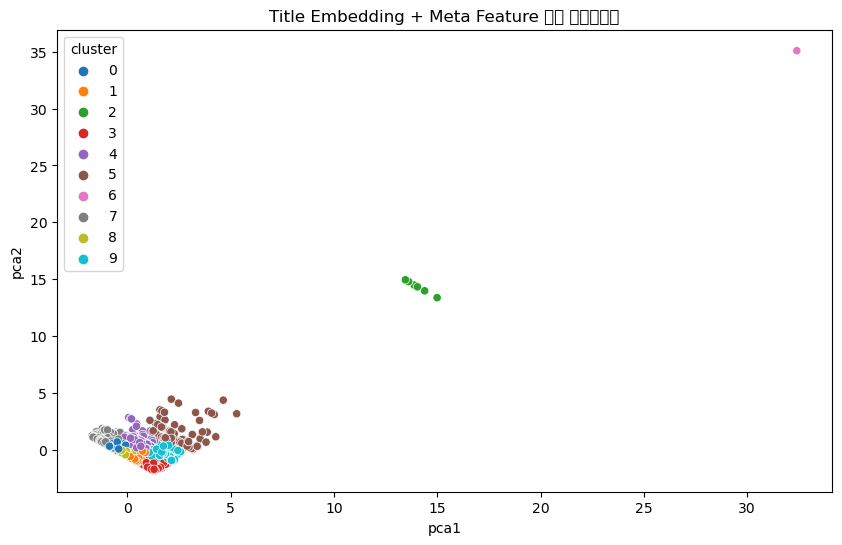

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 🔹 1. title_embedding.csv 로드
embedding_df = pd.read_csv("title_embeddings.csv")

# 🔹 2. 전체 피처가 포함된 메타데이터 df (이미 있다고 가정)
# 예: df = pd.read_csv("full_data.csv")
# df에는 video_id, subscriber_count, title_length가 포함돼 있어야 함

# 🔹 3. 병합
merged_df = pd.merge(embedding_df, title_df[['video_id', 'subscriber_count', 'title_length']], on='video_id', how='inner')

# 🔹 4. 피처 추출
embedding_cols = [col for col in merged_df.columns if col.startswith("emb_")]
X_embedding = merged_df[embedding_cols].values
X_meta = merged_df[['subscriber_count', 'title_length']].fillna(0).values

# 🔹 5. 정규화 + 결합
X_combined = np.hstack([X_meta, X_embedding])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_combined)

# 🔹 6. KMeans 클러스터링
k = 10  # 군집 수
kmeans = KMeans(n_clusters=k, random_state=42)
merged_df['cluster'] = kmeans.fit_predict(X_scaled)

# 🔹 7. 시각화 (PCA 2D)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
merged_df['pca1'] = X_pca[:, 0]
merged_df['pca2'] = X_pca[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='pca1', y='pca2', hue='cluster', palette='tab10')
plt.title("Title Embedding + Meta Feature 기반 클러스터링")
plt.show()

# 🔹 8. 저장
#merged_df.to_csv("merged_clustered_result.csv", index=False)
